# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 2 - Image Classification and Segmentation
---

### <a style='color:red'> Due Date: 15.5.2023 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* **DON'T** submit the CIFAR-10 dataset in your submission, we have a local copy of it.
* **DON'T** submit the trained networks, but make sure to document every result you get.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).
* **Do** write the code in the notebook itself.

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Classifier
---
In this part we are going to examine the performance of a classical classifier over images from the **Canadian Institute For Advanced Research (CIFAR-10)**  Dataset. 

* The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
  * There is also CIFAR-100, with 100 classes.
* The classes are completely mutually exclusive. For example, there is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.
* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Official Site</a>


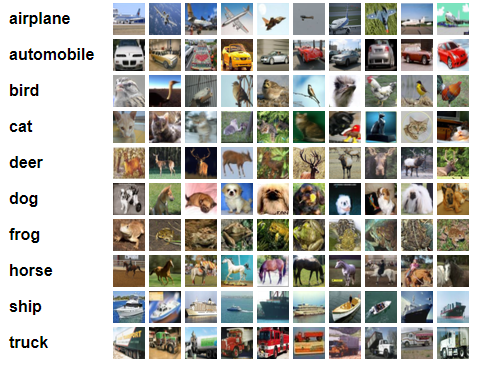


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import cv2
import torchvision
from sklearn.neighbors import KNeighborsClassifier
import time
import os
import torch.nn as nn

In [2]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

1. Load the CIFAR-10 training and test set with PyTorch (<a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10">read more here</a>). Display 5 images from the training set with their labels as title.

In [3]:
# Load the CIFAR-10 training set and transform to tensor
transform=torchvision.transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#creating dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)


100%|██████████| 170498071/170498071 [00:13<00:00, 12846053.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
img,lab=(next(iter(trainloader)))
img.shape
# lab.shape

torch.Size([5, 3, 32, 32])

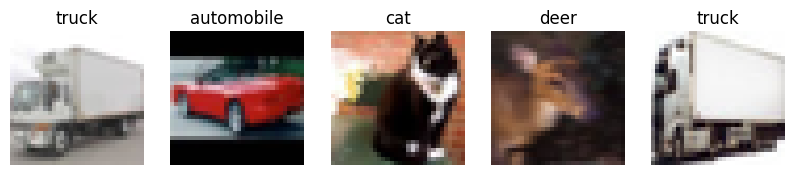

In [5]:
# get the class labels
classes = trainset.classes

# Display 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,2.5))

for i, (image, label) in enumerate(trainloader):
    if i == 5:
        break
    ax = axes[i]
    ax.imshow(torchvision.transforms.ToPILImage()(image[0]))
    ax.set_title(classes[label[0]])
    ax.axis('off')

plt.show()

2. Build a K-Nearest Neighbors (K-NN) classifier (hint: `sklearn.neighbors.KNeighborsClassifier`), with `n_neighbors=10`, to classify CIFAR-10: Load 10,000 samples from the training set and train the model. 

  **Note**: The model's input dimension should be : `(n_samples, n_features)`, Thus you need to convert each color channel to row representation and then concatenate the 3 color channels.

In [6]:
train_images = trainset.data[:10000]
train_labels = np.array(trainset.targets[:10000])

# Reshape the data to (n_samples, n_features) format
train_images = train_images.reshape(train_images.shape[0], -1)

# Concatenate the three color channels
train_images = np.concatenate([train_images[:, :1024], train_images[:, 1024:2048], train_images[:, 2048:]], axis=1)

# initialize K-NN classifier
knn = KNeighborsClassifier(n_neighbors=10)
#Training the classifier
knn.fit(train_images, train_labels)


KNeighborsClassifier(n_neighbors=10)

3. Load 1,000 samples from CIFAR-10 test set and check the performance of the K-NN classifier over these samples. What is the accuracy obtained? View the results using a <a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62">confusion matrix </a>

Files already downloaded and verified
Test accuracy: 0.2880


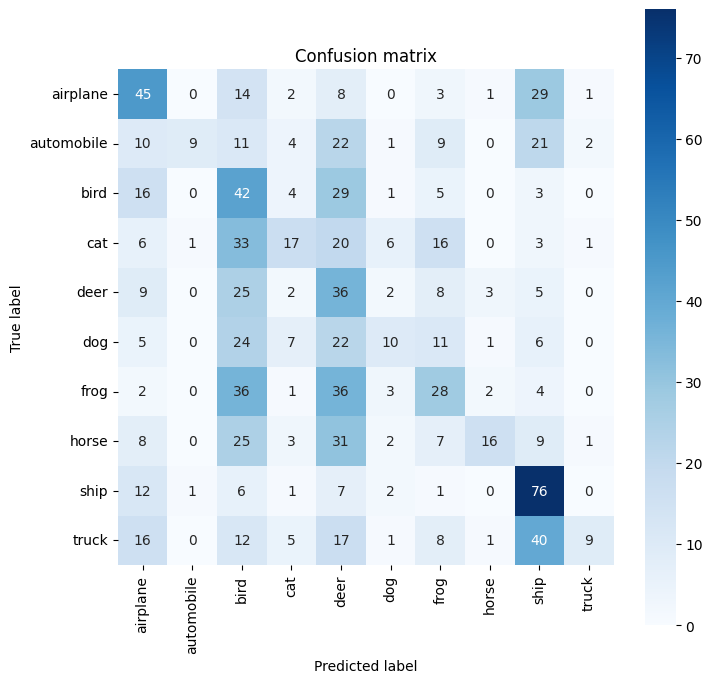

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the CIFAR-10 test set and extract the first 1,000 samples
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_images = testset.data[:1000]
test_labels = np.array(testset.targets[:1000])
test_images = test_images.reshape(test_images.shape[0], -1)
test_images = np.concatenate([test_images[:, :1024], test_images[:, 1024:2048], test_images[:, 2048:]], axis=1)
test_pred = knn.predict(test_images)
test_acc = accuracy_score(test_labels, test_pred)
print(f'Test accuracy: {test_acc:.4f}')
cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

4. Compare the model's accuracy for different number of neighbors ($1 \leq K \leq 30$ ). Display the results in a graph of accuracy as function of $K$.

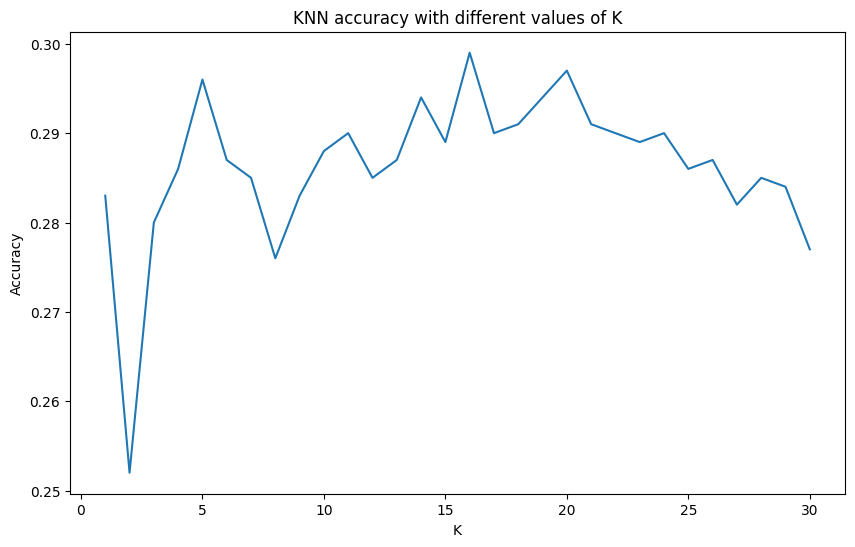

In [8]:
test_acc_lst=[]
for k in range(1,31,1):
    # initialize K-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    #Training the classifier
    knn.fit(train_images, train_labels)
    test_pred = knn.predict(test_images)
    test_acc = accuracy_score(test_labels, test_pred)
    test_acc_lst.append(test_acc)
x=range(1,31,1)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(x,test_acc_lst)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.title('KNN accuracy with different values of K')
plt.show()

#### Part 2 - Design and Build a CNN Classifier
---
In this part you are going to design a deep convolutional neural network to classify CIFAR-10 dataset. 

1. Use the CNN from tutorials 3-4 (`SvhnCnn()`) and train it on the CIFAR-10 dataset (**keep the architecture the same**) for the same number of **epochs** with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?
    * Your test accuracy from this section will be your **baseline** accuracy for sections 2-3.

In [9]:
len(classes)

10

In [10]:
def convert_to_imshow_format(image):
  image = image / (image.abs().max() * 2) + 0.5
  image = image.numpy()
  return image.transpose(1,2,0)

In [11]:
class SvhnCNN(nn.Module):
    def __init__(self):
        super(SvhnCNN,self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            )

        self.fc = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.conv_layer(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


In [12]:
dummy_input = torch.zeros([128, 3, 32, 32])
dummy_model = SvhnCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0),-1)
print(dummy_output.shape)

torch.Size([128, 128, 8, 8])
torch.Size([128, 8192])


In [13]:
#TPU

# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [14]:
# device_props = torch.cuda.get_device_properties(device)
# num_workers = device_props.multi_processor_count
# num_workers

In [15]:
#hyper‑parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20
#dataloaders‑creating batches and shuffling the data
testloader = torch.utils.data.DataLoader(
testset, batch_size=batch_size, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
print(f'Using {device}')
#loss criterion
criterion = nn.CrossEntropyLoss()
#buildourmodelandsendittothedevice
model = SvhnCNN().to(device)
#optimizer‑SGD,Adam,RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
def calculate_accuracy(model, dataloader, device):
  model.eval()
  total_correct = 0 
  total_images = 0
  confusion_matrix = np.zeros([10,10], int)
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total_images += labels.size(0)
      total_correct += (predicted == labels).sum().item()
      for i, l in enumerate(labels):
        confusion_matrix[l.item(), predicted[i].item()] += 1
  model_accuracy = total_correct / total_images * 100
  return model_accuracy, confusion_matrix


In [17]:
 # training loop
for epoch in range(1, epochs + 1):
  model.train() # put in training mode
  running_loss = 0.0
  epoch_time = time.time()
  for i, data in enumerate(trainloader, 0):
  # get the inputs
    inputs, labels = data
    # send them to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward + backward + optimize
    outputs = model(inputs) # forward pass
    loss = criterion(outputs, labels) # calculate the loss
    # always the same 3 steps
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backpropagation
    optimizer.step() # update parameters
    # print statistics
    running_loss += loss.data.item()
  # Normalizing the loss by the total number of train batches
  running_loss /= len(trainloader)
  # Calculate training/test set accuracy of the existing model
  train_accuracy, _ = calculate_accuracy(model, trainloader, device)
  test_accuracy, _ = calculate_accuracy(model, testloader, device)
  log = "Epoch:{}|Loss:{:.4f}|Training accuracy:{:.3f}%|Test accuracy:{:.3f}%|".format(epoch, running_loss,train_accuracy,test_accuracy)
  epoch_time = time.time() - epoch_time
  log += "Epoch Time: {:.2f} secs".format(epoch_time)
  print(log)

  # save model
  if epoch % 20 == 0:
    print('==> Saving model ...')
    state = {
    'net': model.state_dict(),
    'epoch': epoch,
    }
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    torch.save(state, './checkpoints/cifar10_cnn_ckpt.pth')

print('==> Finished Training ...')

Epoch:1|Loss:1.6077|Training accuracy:51.952%|Test accuracy:52.220%|Epoch Time: 31.81 secs
Epoch:2|Loss:1.2573|Training accuracy:60.508%|Test accuracy:59.930%|Epoch Time: 23.57 secs
Epoch:3|Loss:1.0883|Training accuracy:66.036%|Test accuracy:64.540%|Epoch Time: 23.73 secs
Epoch:4|Loss:0.9861|Training accuracy:69.756%|Test accuracy:67.720%|Epoch Time: 24.28 secs
Epoch:5|Loss:0.9034|Training accuracy:70.242%|Test accuracy:67.130%|Epoch Time: 24.12 secs
Epoch:6|Loss:0.8337|Training accuracy:72.930%|Test accuracy:69.610%|Epoch Time: 24.14 secs
Epoch:7|Loss:0.7822|Training accuracy:75.962%|Test accuracy:71.490%|Epoch Time: 24.01 secs
Epoch:8|Loss:0.7308|Training accuracy:77.968%|Test accuracy:72.940%|Epoch Time: 23.70 secs
Epoch:9|Loss:0.6870|Training accuracy:78.788%|Test accuracy:73.280%|Epoch Time: 23.81 secs
Epoch:10|Loss:0.6420|Training accuracy:81.720%|Test accuracy:75.170%|Epoch Time: 24.42 secs
Epoch:11|Loss:0.5961|Training accuracy:83.182%|Test accuracy:75.810%|Epoch Time: 24.44 se

test accuracy: 78.960%


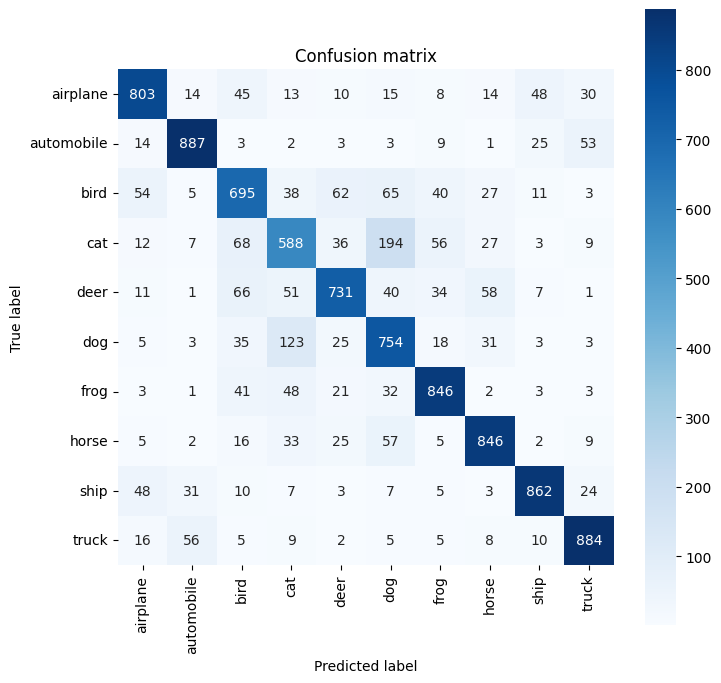

In [18]:
#load model, calculate accuracy and confusion matrix
model = SvhnCNN().to(device)
state = torch.load('./checkpoints/cifar10_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)

print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

2. Design your own Convolutional Neural Network (CNN) to classify CIFAR-10. You can modify the network from section 1,but **you must get a better result than your baseline accuracy from section 1**.
    * You **need** to use one of the following in your CNN - Residual block, activation function PReLU, activation function Leaky ReLU, Group Normalization, Exponential moving average (EMA).
      Explain the technique you have chosen.
    * Describe the chosen architecture, how many layers? What activations did you choose? What are the filter sizes? Did you use fully-connected layers (if you did, explain their sizes)?
    * What is the input dimension? What is the output dimension?
    * Calculate the number of parameters (weights) in the network.

  **Note:** 
    * The new network should perform better over the same task (i.e. using the same data with the same hyper-parameters. Change only the network architecture).
    * Students who reach the highest accuracy over the test set will receive **5 bonus points** for this exercise.


3. Train the classifier (preferably on a **GPU - use Colab for this part** if you don't have a GPU).
    * Describe the hyper-parameters of the model (batch size, epochs, learning rate....). How did you tune your model? Did you use a validation set to tune the model? (<a href="https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123">Separating to train/validation/test in PyTorch</a>)
    * What is the final accuracy on the test set?

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.direct = nn.Sequential(
              (nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
              (nn.BatchNorm2d(self.out_channels)),
              (nn.LeakyReLU(negative_slope=0.1)),
              (nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
              (nn.BatchNorm2d(self.out_channels)),
              (nn.LeakyReLU(negative_slope=0.1)),
        )
        
        self.skip_path = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(self.out_channels)
        ) 
        
            
    def forward(self, x):
        out = self.direct(x)
        skip = self.skip_path(x)
        out += skip
        return out


class DaniellaShaharNet(nn.Module):
    def __init__(self):
        super(DaniellaShaharNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1),
            ResidualBlock(in_channels=32, out_channels=64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            ResidualBlock(in_channels=128, out_channels=256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            ResidualBlock(in_channels=256, out_channels=512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=512, out_channels=256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding=1,stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1)
        )

        self.fc = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4608, 64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [20]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 4482058


In [21]:
dummy_input = torch.zeros([128, 3, 32, 32])
dummy_model = DaniellaShaharNet()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0),-1)
print(dummy_output.shape)

torch.Size([128, 128, 6, 6])
torch.Size([128, 4608])


In [22]:
model = DaniellaShaharNet().to(device)
#optimizer‑SGD,Adam,RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 6956874


In [24]:
 # training loop
test_acc = []
for epoch in range(1, epochs + 1):
  model.train() # put in training mode
  running_loss = 0.0
  epoch_time = time.time()
  for i, data in enumerate(trainloader, 0):
  # get the inputs
    inputs, labels = data
    # send them to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward + backward + optimize
    outputs = model(inputs) # forward pass
    loss = criterion(outputs, labels) # calculate the loss
    # always the same 3 steps
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backpropagation
    optimizer.step() # update parameters
    # print statistics
    running_loss += loss.data.item()
  # Normalizing the loss by the total number of train batches
  running_loss /= len(trainloader)
  # Calculate training/test set accuracy of the existing model
  train_accuracy, _ = calculate_accuracy(model, trainloader, device)
  test_accuracy, _ = calculate_accuracy(model, testloader, device)
  test_acc.append(test_accuracy)
  log = "Epoch:{}|Loss:{:.4f}|Training accuracy:{:.3f}%|Test accuracy:{:.3f}%|".format(epoch, running_loss,train_accuracy,test_accuracy)
  epoch_time = time.time() - epoch_time
  log += "Epoch Time: {:.2f} secs".format(epoch_time)
  print(log)

  # save best model
  # if epoch % epochs == 0:
  if epoch==1:
    continue
  elif test_acc[-1]==max(test_acc):
    print('==> Saving model ...')
    state = {
    'net': model.state_dict(),
    'epoch': epoch,
    }
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    torch.save(state, './checkpoints/cifar10_cnn_ckpt2.pth')


print('==> Finished Training ...')

Epoch:1|Loss:1.3255|Training accuracy:60.068%|Test accuracy:58.270%|Epoch Time: 50.74 secs
Epoch:2|Loss:0.8622|Training accuracy:71.176%|Test accuracy:68.270%|Epoch Time: 50.77 secs
==> Saving model ...
Epoch:3|Loss:0.6947|Training accuracy:78.016%|Test accuracy:74.190%|Epoch Time: 49.43 secs
==> Saving model ...
Epoch:4|Loss:0.5918|Training accuracy:76.000%|Test accuracy:72.520%|Epoch Time: 48.46 secs
Epoch:5|Loss:0.5151|Training accuracy:84.692%|Test accuracy:78.770%|Epoch Time: 48.75 secs
==> Saving model ...
Epoch:6|Loss:0.4497|Training accuracy:84.238%|Test accuracy:77.690%|Epoch Time: 48.36 secs
Epoch:7|Loss:0.3956|Training accuracy:86.952%|Test accuracy:79.000%|Epoch Time: 49.23 secs
==> Saving model ...
Epoch:8|Loss:0.3481|Training accuracy:91.342%|Test accuracy:82.120%|Epoch Time: 48.04 secs
==> Saving model ...
Epoch:9|Loss:0.3062|Training accuracy:89.720%|Test accuracy:79.960%|Epoch Time: 48.39 secs
Epoch:10|Loss:0.2694|Training accuracy:93.386%|Test accuracy:82.490%|Epoch T

test accuracy: 84.220%


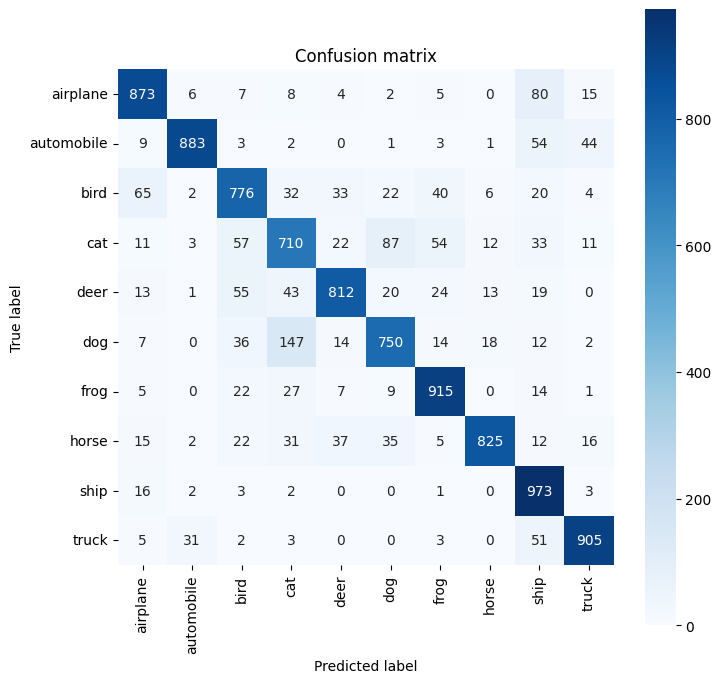

In [25]:
#load model, calculate accuracy and confusion matrix
model = DaniellaShaharNet().to(device)
state = torch.load('./checkpoints/cifar10_cnn_ckpt2.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)

print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [26]:
# !pip install torchviz

In [27]:
# create a diagrame of DaniellaShaharNet :
# from torchviz import make_dot

# x = torch.randn(1, 3, 32, 32).to(device)
# y = model(x)

# make_dot(y, params=dict(model.named_parameters()))

### use validation set to choose hyperparameter

In [28]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           augment=False,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # define transforms
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])


    # load the dataset
    train_dataset = datasets.CIFAR10(root=data_dir, train=True,
                                     download=True, transform=train_transform)

    valid_dataset = datasets.CIFAR10(root=data_dir, train=True,
                                     download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                    batch_size=batch_size, sampler=train_sampler,
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                    batch_size=batch_size, sampler=valid_sampler,
                    num_workers=num_workers, pin_memory=pin_memory)

    return (train_loader, valid_loader)



In [29]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True):
    """
    Utility function for loading and returning a multi-process
    test iterator over the MNIST dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    dataset = datasets.CIFAR10(root=data_dir,
                               train=False,
                               download=True,
                               transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size,
                                              shuffle=shuffle,  num_workers=num_workers,
                                        pin_memory=pin_memory)

    return data_loader

In [30]:
data_dir = r'C:\Users\rasht\Documents\computer vision\homework2\ee046746_hw2_classification\data'
# batch_size=256
#
# trainloader,val_loader = get_train_valid_loader(data_dir,batch_size,42)
# testloader = get_test_loader(data_dir,batch_size)

In [31]:
# import itertools
# import torch.optim as optim
# import torch.nn as nn

# # Define the hyperparameters to tune
# learning_rates = [0.0001, 0.001]
# batch_sizes = [128, 265]
# num_epochs = [1, 20]

# # Create a grid of hyperparameters to search over
# hyperparameters = itertools.product(learning_rates, batch_sizes, num_epochs)

# best_loss = float('inf')
# best_hyperparameters = None

# # Iterate over all hyperparameters
# for lr, batch_size, num_epoch in hyperparameters:

#     # Create data loaders for the training and validation datasets
#     trainloader,val_loader = get_train_valid_loader(data_dir,batch_size,42)

#     # Define the model and optimizer
#     model = DaniellaShaharNet()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.CrossEntropyLoss()

#     # Train the model on the training dataset
#     for epoch in range(num_epoch):
#         for batch_idx, (data, target) in enumerate(trainloader):
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#     # Evaluate the model on the validation dataset
#     with torch.no_grad():
#         total_loss = 0
#         total_correct = 0
#         total_examples = 0
#         for data, target in val_loader:
#             output = model(data)
#             loss = criterion(output, target)
#             total_loss += loss.item()
#             total_correct += (output.argmax(dim=1) == target).sum().item()
#             total_examples += data.shape[0]
#         avg_loss = total_loss / len(val_loader)
#         avg_accuracy = total_correct / total_examples

#     # Update the best hyperparameters if necessary
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         best_hyperparameters = (lr, batch_size, num_epoch)

# print(f"Best hyperparameters: learning_rate={best_hyperparameters[0]}, batch_size={best_hyperparameters[1]}, num_epochs={best_hyperparameters[2]}")




In [32]:
# Train a final model using the selected hyperparameters on the combined training and validation datasets

# lr=0.001
# batch_size=512
# num_epoch=20
# best_hyperparameters = (lr, batch_size, num_epoch)
# trainloader,val_loader = get_train_valid_loader(data_dir,best_hyperparameters[1],42)


#NEW Selected hyper‑parameters got us 87%
batch_size = 64
learning_rate = 1e-3
epochs = 60

#dataloaders‑creating batches and shuffling the data
testloader = torch.utils.data.DataLoader(
testset, batch_size=batch_size, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
print(f'Using {device}')
#loss criterion
criterion = nn.CrossEntropyLoss()
#buildourmodelandsendittothedevice
model = DaniellaShaharNet().to(device)
#optimizer‑SGD,Adam,RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda


In [33]:
 # training loop
test_acc = []
for epoch in range(1, epochs + 1):
  model.train() # put in training mode
  running_loss = 0.0
  epoch_time = time.time()
  for i, data in enumerate(trainloader, 0):
  # get the inputs
    inputs, labels = data
    # send them to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward + backward + optimize
    outputs = model(inputs) # forward pass
    loss = criterion(outputs, labels) # calculate the loss
    # always the same 3 steps
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backpropagation
    optimizer.step() # update parameters
    # print statistics
    running_loss += loss.data.item()
  # Normalizing the loss by the total number of train batches
  running_loss /= len(trainloader)
  # Calculate training/test set accuracy of the existing model
  train_accuracy, _ = calculate_accuracy(model, trainloader, device)
  test_accuracy, _ = calculate_accuracy(model, testloader, device)
  test_acc.append(test_accuracy)
  log = "Epoch:{}|Loss:{:.4f}|Training accuracy:{:.3f}%|Test accuracy:{:.3f}%|".format(epoch, running_loss,train_accuracy,test_accuracy)
  epoch_time = time.time() - epoch_time
  log += "Epoch Time: {:.2f} secs".format(epoch_time)
  print(log)

  # save best model
  # if epoch % epochs == 0:
  if epoch==1:
    continue
  elif test_acc[-1]==max(test_acc):
    print('==> Saving model ...')
    state = {
    'net': model.state_dict(),
    'epoch': epoch,
    }
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    torch.save(state, './checkpoints/cifar10_cnn_ckpt3.pth')


print('==> Finished Training ...')

Epoch:1|Loss:1.2163|Training accuracy:62.734%|Test accuracy:62.050%|Epoch Time: 53.83 secs
Epoch:2|Loss:0.8034|Training accuracy:74.690%|Test accuracy:71.480%|Epoch Time: 53.39 secs
==> Saving model ...
Epoch:3|Loss:0.6543|Training accuracy:78.420%|Test accuracy:75.440%|Epoch Time: 53.48 secs
==> Saving model ...
Epoch:4|Loss:0.5540|Training accuracy:84.584%|Test accuracy:79.680%|Epoch Time: 53.52 secs
==> Saving model ...
Epoch:5|Loss:0.4735|Training accuracy:87.508%|Test accuracy:81.570%|Epoch Time: 54.35 secs
==> Saving model ...
Epoch:6|Loss:0.4113|Training accuracy:88.464%|Test accuracy:81.490%|Epoch Time: 53.75 secs
Epoch:7|Loss:0.3560|Training accuracy:90.930%|Test accuracy:83.330%|Epoch Time: 53.31 secs
==> Saving model ...
Epoch:8|Loss:0.3073|Training accuracy:92.256%|Test accuracy:83.600%|Epoch Time: 53.41 secs
==> Saving model ...
Epoch:9|Loss:0.2664|Training accuracy:92.250%|Test accuracy:82.830%|Epoch Time: 53.42 secs
Epoch:10|Loss:0.2254|Training accuracy:95.660%|Test acc

test accuracy: 87.360%


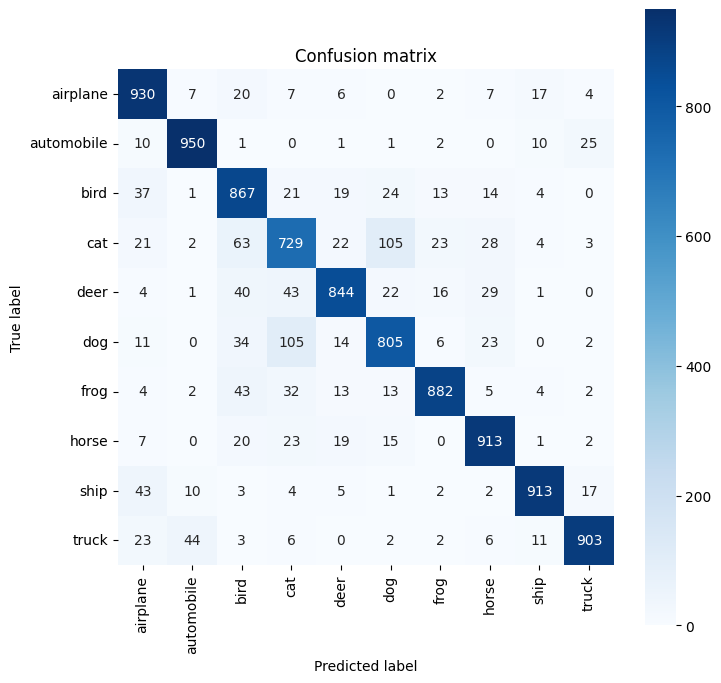

In [34]:
# testloader = get_test_loader(data_dir,
#                     batch_size,
#                     shuffle=True,
#                     num_workers=1,
#                     pin_memory=True)

#load model, calculate accuracy and confusion matrix
model = DaniellaShaharNet().to(device)
state = torch.load('./checkpoints/cifar10_cnn_ckpt3.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)

print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

#### Part 3 - Analyzing a Pre-trained CNN & Adverserial Examples
---
In this part you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>

1. Load a pre-trained VGG16 with PyTorch using `torchvision.models.vgg16(pretrained=True, progress=True, **kwargs)` (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (`model.eval()`). 

In [ ]:
from torchvision.models import vgg16 as vgg16
model = vgg16(pretrained=True, progress=True)
model.eval()

C:\Users\rasht\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\rasht\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. Load the images in the `./data/birds` folder and display them.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "drive/MyDrive/ee046746_hw2_classification/data"

In [ ]:
from PIL import Image
import os
def load_images(folder_path):
    images = []
    # Loop through all the images in the folder and display them
    for filename in os.listdir(folder_path):
        if filename.endswith('jpg'):
            # Load the image
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # image = cv2.imread(image_path)
            images.append(image)
    return images

In [ ]:
# c = "cow.jpg"
# c.endswith('jpg')

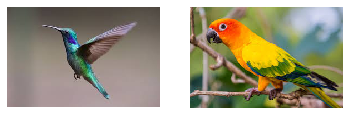

In [ ]:
folder_path = './data/birds'
images = load_images(folder_path)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[0])
axs[0].axis('off')
axs[1].imshow(images[1])
axs[1].axis('off')
plt.show()

3. Pre-process the images to fit VGG16's architecture. What steps did you take?



The inference transforms are available at VGG16_BN_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
import torchvision.transforms as transforms
def preprocess(image):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      normalize
  ])
  image = transform(image).unsqueeze(0)
  return image

In [ ]:
images_vgg = []
for img in images:
  images_vgg.append(preprocess(img))

print(images_vgg[0].shape)
print(type(images_vgg[0]))

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>


4. Feed the images (forward pass) to the model. What are the outputs? To convert from class index to label, use the supplied `./data/imagenet1000_clsidx_to_labels.txt` file

In [ ]:
with open("./data/imagenet1000_clsidx_to_labels.txt", "r") as f:
    labels = np.array(f.read().splitlines())

In [ ]:
labels[0]

"{0: 'tench, Tinca tinca',"

In [ ]:
# Forward pass through the model
with torch.no_grad():
    for img in images_vgg:
        output = model(img) #1X1000 tensor

    # Convert the output to probabilities using softmax
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get the index of the predicted class
        predicted_index = torch.argmax(probabilities).item()
        print("Predicted label: ", labels[predicted_index])
        print("Probability: {:.4f}".format(probabilities[predicted_index].item()))

Predicted label:   94: 'hummingbird',
Probability: 0.6281
Predicted label:   90: 'lorikeet',
Probability: 0.6457


5. Find an image of a bird/cat/dog on the internet, display it and feed it to network. What are the outputs?

In [ ]:
#Loading the image
image_path = "./data/my_data/dog_from_internet.jpg"
dog = Image.open(image_path)

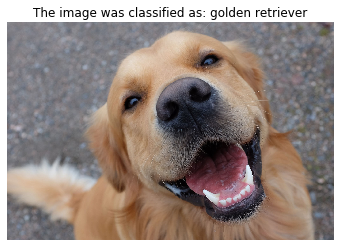

In [ ]:
#preprocessing and feeding to the network
dog_vgg = preprocess(dog)
with torch.no_grad():
    output = model(dog_vgg) #1X1000 tensor

# Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the index of the predicted class
    predicted_index = torch.argmax(probabilities).item()

label_name = labels[predicted_index].split(':')[1][2:-2]
#plotting
fig = plt.figure()
plt.imshow(dog)
plt.axis('off')
plt.title(f'The image was classified as: {label_name}')
plt.show()

6. For the first 3 filters in the *first layer* of VGG16, plot the filters, and then plot their response (their output) for the image from section 5. Explain what do you see.
    * Consult `ee046746_appndx_visualizing_cnn_filters.ipynb` to refresh your memory.

In [ ]:
# helper functions
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image


def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item())

def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

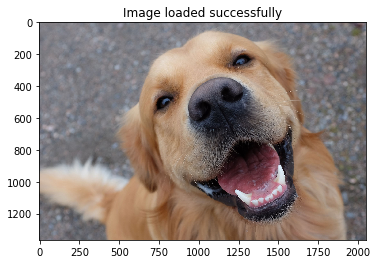

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dog_img = load_image(r"./data/my_data/dog_from_internet.jpg")
prep_img = normalize(dog_img, device)

In [ ]:
# functions to visualize the kernels   
    
def plot_filters_multi_channel(t,number_of_filters_to_plot):
    
    # get the number of kernals
    num_kernels = t.shape[0]    
    
    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels
    
    # set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    # looping through all the kernels
    # for i in range(t.shape[0]):

    # looping through the first number_of_filters_to_plot 
    for i in range(number_of_filters_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        # for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
#     plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    
    
def plot_weights(model, layer_num):
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    # checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if weight_tensor.shape[1] == 3:
            plot_filters_multi_channel(weight_tensor,3)
        else:
            print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

In [ ]:
def layer_outputs(image, model):
    modulelist = list(model.features.modules())
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))

    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(30, 50))

    for i in range(len(output_im)):
        a = fig.add_subplot(8, 4, i+1)
        imgplot = plt.imshow(output_im[i])
        a.set_axis_off()
        a.set_title(names[i].partition('(')[0], fontsize=30)
    plt.tight_layout()
#     plt.savefig('layer_outputs.jpg', bbox_inches='tight')

In [ ]:
def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize:
            output = image
            name = str(layer)

    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])

    fig = plt.figure(figsize=(10, 10))

    for i in range(3):
        ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_axis_off()
    plt.tight_layout()

In [ ]:
def plot_filters_response(image, model, num_filters=3):
    # Get the first layer
    layer = model.features[0]

    # Extract the first num_filters filters from the layer
    filters = layer.weight.data[:, :num_filters].cpu()

    # Plot the filters
    # fig = plt.figure(figsize=(10, 5))
    # for i in range(num_filters):
    #     ax = fig.add_subplot(1, num_filters, i+1)
    #     ax.imshow(filters[i].squeeze(), cmap='gray')
    #     ax.set_title(f'Filter {i+1}')
    #     ax.set_axis_off()

    # Compute the response of the filters to the image
    response = layer(image)
    response = response[:, :num_filters].detach().cpu().numpy()

    # Plot the response
    fig = plt.figure(figsize=(10, 5))
    for i in range(num_filters):
        ax = fig.add_subplot(1, num_filters, i+1)
        ax.imshow(response[0, i],cmap='gray')
        ax.set_title(f'Filter {i+1} response')
        ax.set_axis_off()

    plt.show()


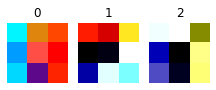

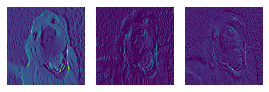

In [ ]:
plot_weights(model,0)
filter_outputs(prep_img,model,1)
# plot_filters_response(prep_img,model,3)

In [ ]:
def filter_outputs(image, model, layer_to_visualize, number_of_filters):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize:
            output = image
            name = str(layer)

    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(number_of_filters):
        filters.append(output[i,:,:])

    fig = plt.figure(figsize=(10, 10))

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_axis_off()
    plt.tight_layout()

In [ ]:
# weight_tensor = model.features[0].weight.data
# plot_filters_multi_channel(weight_tensor,3)
# filter_outputs(dog_vgg, model, 0,3)

7. For each image in the `./data/dogs` and `./data/cats`folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as `FC7`) of the VGG16 model. Which layer did you pick? What is the size of the feature space?
    * You need to write a function that does the feed forward manually until the desired layer. See the example in `ee046746_appndx_visualizing_cnn_filters.ipynb`.

In [ ]:
dogs = load_images('./data/dogs')
cats = load_images('./data/cats')
vgg_dogs = []
vgg_cats = []
for img in dogs:
  vgg_dogs.append(preprocess(img))
for img in cats:
  vgg_cats.append(preprocess(img))

In [ ]:
import copy
def fc7_output(image,model):
    # Create a copy of the model
    model_copy = copy.deepcopy(model)
    # remove the fc8 layer
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model_copy.classifier = new_classifier
    output = model_copy(image)
    return torch.squeeze(output)

In [ ]:
fc7_output(vgg_cats[0],model).shape

torch.Size([4096])

In [ ]:
cats_features = torch.stack([fc7_output(tensor,model) for tensor in vgg_cats])
dogs_features = torch.stack([fc7_output(tensor,model) for tensor in vgg_dogs])

In [ ]:
cats_features[0].shape

torch.Size([4096])

8. Build a Support Vector Machine (SVM) classifier (hint: `sklearn.svm.LinearSVC`) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the `scikit-learn` library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

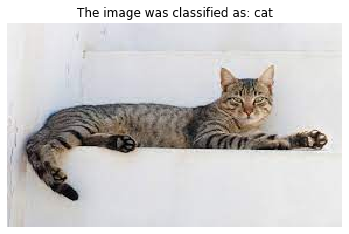

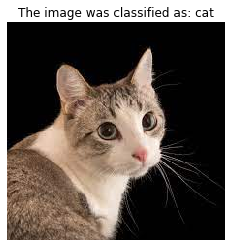

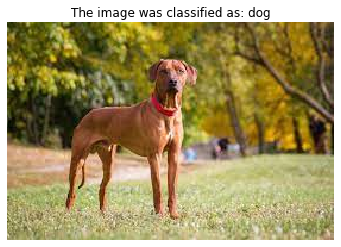

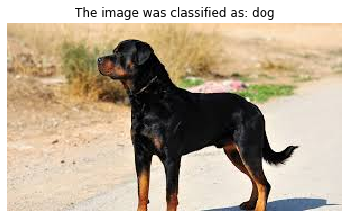

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# # Concatenate the features into a single matrix
X_train = torch.cat((dogs_features, cats_features)).detach().numpy()
y_train = [1] * len(dogs_features) + [0] * len(cats_features)

# Train a Linear SVM classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

# Extract features from the test images

test_features = []
test_images = load_images(r'./data/my_data/test_data_from_internet')
for img in test_images:
    tensor=preprocess(img)
    feature = fc7_output(tensor, model).detach().numpy()
    test_features.append(feature)

# Make predictions on the test images using the trained classifier
y_pred = clf.predict(test_features)

# # Print the predicted labels and display image
for i, image in enumerate(test_images):
    fig = plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'The image was classified as: {"dog" if y_pred[i]==1 else "cat"}')
plt.show()


Adversarial examples are specialised images created with the purpose of confusing a neural network, resulting in the misclassification of a given input. In this exercise you are going to create an adversarial images first by using augmentations and then by using segmentation.

9. Pick an image of an animal in its natural habitat (e.g., cow on grass fields, zebra in the safari etc. You can also use the supplied ./data/cow.jpg or ./data/sheep.jpg ).
Display the image you chose and feedforward it to the pre-trained network. What is the network's prediction? To convert from class index to label, use the supplied
./data/imagenet1000_clsidx_to_labels.txt file.
10. Apply the following 3 transformations to create 3 *new* images from the image from section 2, and display them (`openCV` has functions for all):
    * One **geometric transformation** (rotation, scaling, translation, warping...).
    * One **color transformation** (thresholding, different color space, hue, saturation, brightness, contrast...).
    * One **filter** (any filter you want).
11. Feed the transformed images to network, what is the output? is it different from section 9? Discuss the reasons for that to happen.

In [ ]:
model = vgg16(pretrained=True, progress=True)
model.eval()

C:\Users\rasht\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\rasht\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

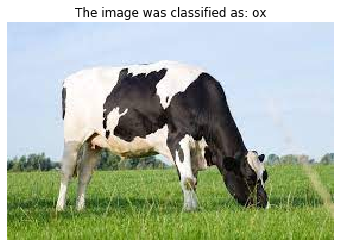

In [ ]:
#9
cow = Image.open(r'./data/my_data/cow_internet.jpg')

cow_vgg = preprocess(cow)
with torch.no_grad():
    output = model(cow_vgg) #1X1000 tensor

# Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the index of the predicted class
    predicted_index = torch.argmax(probabilities).item()

label_name = labels[predicted_index].split(':')[1][2:-2]
#plotting
fig = plt.figure()
plt.imshow(cow)
plt.axis('off')
plt.title(f'The image was classified as: {label_name}')
plt.show()

In [ ]:
#10
# Convert PIL image to OpenCV image
img_cv2 = cv2.cvtColor(np.array(cow), cv2.COLOR_RGB2BGR)

augmented_images = []
# Geometric transformation: rotate the image 45 degrees clockwise
rows, cols = img_cv2.shape[:2]
M = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1)
rotated_img_cv2 = cv2.warpAffine(img_cv2, M, (cols, rows))
rotated_img = Image.fromarray(cv2.cvtColor(rotated_img_cv2, cv2.COLOR_BGR2RGB))
augmented_images.append(rotated_img)

# Color transformation: convert the image to YCrCb color space
gray_img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2YCrCb)
YCrCb_img = Image.fromarray(gray_img_cv2)
augmented_images.append(YCrCb_img)

# Filter: apply a Gaussian blur with a 5x5 kernel
blurred_img_cv2 = cv2.GaussianBlur(img_cv2, (5, 5), 0)
blurred_img = Image.fromarray(cv2.cvtColor(blurred_img_cv2, cv2.COLOR_BGR2RGB))
augmented_images.append(blurred_img)


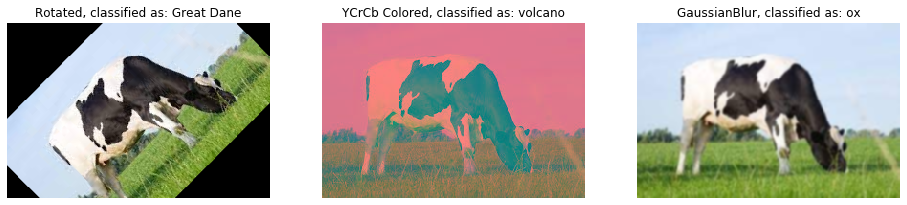

In [ ]:
#11
vgg_augmented_images = [preprocess(img) for img in augmented_images]

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
with torch.no_grad():
    for i,tensor in enumerate(vgg_augmented_images):
        output = model(tensor) #1X1000 tensor

    # Convert the output to probabilities using softmax
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get the index of the predicted class
        predicted_index = torch.argmax(probabilities).item()

        label_name = labels[predicted_index].split(':')[1][2:-2]
        axs[i].imshow(augmented_images[i])
        axs[i].axis('off')
        axs[i].set_title(f'{"Rotated" if i == 0 else "YCrCb Colored" if i == 1 else "GaussianBlur"}, classified as: {label_name}')

plt.show()

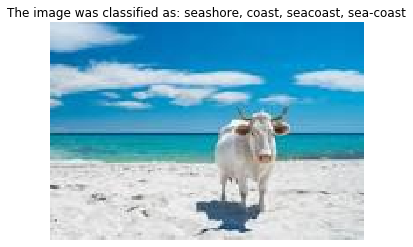

In [ ]:
cow = Image.open(r'./data/my_data/cow_on_the_beach.jpg')

cow_vgg = preprocess(cow)
with torch.no_grad():
    output = model(cow_vgg) #1X1000 tensor

# Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the index of the predicted class
    predicted_index = torch.argmax(probabilities).item()

label_name = labels[predicted_index].split(':')[1][2:-2]
#plotting
fig = plt.figure()
plt.imshow(cow)
plt.axis('off')
plt.title(f'The image was classified as: {label_name}')
plt.show()

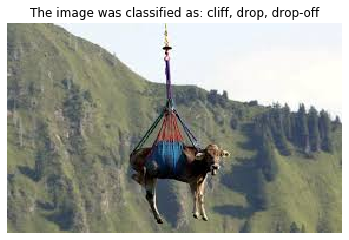

In [ ]:
cow = Image.open(r'./data/my_data/cow_fly.jpg')

cow_vgg = preprocess(cow)
with torch.no_grad():
    output = model(cow_vgg) #1X1000 tensor

# Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the index of the predicted class
    predicted_index = torch.argmax(probabilities).item()

label_name = labels[predicted_index].split(':')[1][2:-2]
#plotting
fig = plt.figure()
plt.imshow(cow)
plt.axis('off')
plt.title(f'The image was classified as: {label_name}')
plt.show()